# **Get Data**
get data from google drive. or manually upload files to colab.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Create Directory Structure**
make dirs and extract files needed

In [0]:
import zipfile
with zipfile.ZipFile('./drive/My Drive/scenes.zip', 'r') as zip_ref:
    zip_ref.extractall('./scenes')
%rm -rf scenes/__MACOSX/

In [0]:
import zipfile
with zipfile.ZipFile('./new.zip', 'r') as zip_ref:
    zip_ref.extractall('./new')
%rm -rf new/__MACOSX/

In [0]:
import os
if not os.path.exists('./resources/'):
    os.mkdir('./resources/')
if not os.path.exists('./model/'):
    os.mkdir('./model/')
if not os.path.exists('./activation/'):
    os.mkdir('./activation/')
if not os.path.exists('./images_epoch/'):
    os.mkdir('./images_epoch/')
# cate = ['mountain', 'forest', 'buildings', 'sea', 'street']

cate = [x[0].split('/')[-1] for x in os.walk('./scenes/')][1:]
for i in range(4, 404, 4):
    new_dir = './images_epoch/{}/'.format(i)
    if not os.path.exists(new_dir):
        os.mkdir(new_dir)
for i in range(4, 404, 4):
    for d in cate:
        new_dir = './images_epoch/{}/{}/'.format(i, d)
        if not os.path.exists(new_dir):
            os.mkdir(new_dir)

for layer in range(1,9):
    if not os.path.exists('./activation/conv{}/'.format(layer)):
        os.mkdir('./activation/conv{}/'.format(layer))
if not os.path.exists('./activation/features/'):
    os.mkdir('./activation/features/')
if not os.path.exists('./activation/input/'):
    os.mkdir('./activation/input/')
if not os.path.exists('./activation/npy/'):
    os.mkdir('./activation/npy/')
if not os.path.exists('./activation/csv/'):
    os.mkdir('./activation/csv/')

In [0]:
import zipfile

with zipfile.ZipFile('./drive/My Drive/Archive.zip', 'r') as zip_ref:
    zip_ref.extractall('./checkpoints')
%ls './checkpoints'

In [0]:
%cp './checkpoints/model-240-290.ckpt' './model/model-240-290.ckpt'

# **Import Classes**

In [0]:
from torchvision import datasets, transforms
from skimage.color import rgb2lab
import torch
import numpy as np

class ImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path,_ = self.imgs[index]
        img = self.loader(path)
        
        if self.transform is not None:
            img_original = self.transform(img)
            img_resize = transforms.Resize(56)(img_original)
            img_original = np.asarray(img_original)

            img_lab = rgb2lab(img_resize)
            img_ab = img_lab[:, :, 1:3]
            img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1)))

            img_original = rgb2lab(img_original)[:,:,0] - 50.0
            img_original = torch.from_numpy(img_original)
            return img_original, img_ab

class ImageLoader(torch.utils.data.DataLoader):
    def __init__(self, data_set, batch_size=40, shuffle=True, num_workers=2, drop_last=True):
        torch.utils.data.DataLoader.__init__(self, 
                                            data_set, 
                                            batch_size = batch_size, 
                                            shuffle = shuffle, 
                                            num_workers = num_workers, 
                                            drop_last=drop_last)


# **Import Util Functions**
This notebook contains utility functions for: <br/>
- converting image file from RGB to LAB <br/>
- computing dataset histogram over ab channels <br/>
- image histogrom on L channel <br/>
- converting npy vector to csv file <br/>
- converting histogram file in .npy format to csv file <br/>
- creating color map in csv file <br/>
- converting image batch shape for training <br/>

In [0]:
%run functions.ipynb

# **Compute Distribution**
compute the distribution of colors into 22x22 bins.

In [9]:
ab_histogram('./scenes/')

############done!


In [0]:
pts = np.load('./resources/pts.npy')
probs = np.load('./resources/probs.npy')
num_color_out = pts.shape[0]

# **Main Model**

In [0]:
import torch
import torch.nn as nn

class Color_model_Vis(nn.Module):
    def __init__(self, num_color_out, num_channel):
        super(Color_model_Vis, self).__init__()
        self.conv1 = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels = 1, out_channels = num_channel, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = num_channel, out_channels = num_channel, kernel_size = 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = num_channel),)
        self.conv2 = nn.Sequential(
            # conv2
            nn.Conv2d(in_channels = num_channel, out_channels = 2 * num_channel, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 2 * num_channel, out_channels = 2 * num_channel, kernel_size = 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = 2 * num_channel),)
        self.conv3 = nn.Sequential(
            # conv3
            nn.Conv2d(in_channels = 2 * num_channel, out_channels = 4 * num_channel, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 4 * num_channel, out_channels = 4 * num_channel, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 4 * num_channel, out_channels = 4 * num_channel, kernel_size = 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = 4 * num_channel),)
        self.conv4 = nn.Sequential(
            # conv4
            nn.Conv2d(in_channels = 4 * num_channel, out_channels = 8 * num_channel, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 8 * num_channel, out_channels = 8 * num_channel, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 8 * num_channel, out_channels = 8 * num_channel, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = 8 * num_channel),)
        self.conv5 = nn.Sequential(
            # conv5
            nn.Conv2d(in_channels = 8 * num_channel, out_channels = 8 * num_channel, kernel_size = 3, stride = 1, padding = 2, dilation = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 8 * num_channel, out_channels = 8 * num_channel, kernel_size = 3, stride = 1, padding = 2, dilation = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 8 * num_channel, out_channels = 8 * num_channel, kernel_size = 3, stride = 1, padding = 2, dilation = 2),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = 8 * num_channel),)
        self.conv6 = nn.Sequential(
            # conv6
            nn.ReLU(),
            nn.Conv2d(in_channels = 8 * num_channel, out_channels = 8 * num_channel, kernel_size = 3, stride = 1, padding = 2, dilation = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 8 * num_channel, out_channels = 8 * num_channel, kernel_size = 3, stride = 1, padding = 2, dilation = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 8 * num_channel, out_channels = 8 * num_channel, kernel_size = 3, stride = 1, padding = 2, dilation = 2),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = 8 * num_channel),)
        self.conv7 = nn.Sequential(
            # conv7
            nn.Conv2d(in_channels = 8 * num_channel, out_channels = 8 * num_channel, kernel_size = 3, stride = 1, padding = 1, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 8 * num_channel, out_channels = 8 * num_channel, kernel_size = 3, stride = 1, padding = 1, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 8 * num_channel, out_channels = 8 * num_channel, kernel_size = 3, stride = 1, padding = 1, dilation = 1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = 8 * num_channel),)
        self.conv8 = nn.Sequential(
            # conv8
            nn.ConvTranspose2d(in_channels = 8 * num_channel, out_channels = 4 * num_channel, kernel_size = 4, stride = 2, padding = 1, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 4 * num_channel, out_channels = 4 * num_channel, kernel_size = 3, stride = 1, padding = 1, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 4 * num_channel, out_channels = 4 * num_channel, kernel_size = 3, stride = 1, padding = 1, dilation = 1),
            nn.ReLU(),)
        self.features = nn.Sequential(
            # conv8_313
            nn.Conv2d(in_channels = 4 * num_channel, out_channels = num_color_out, kernel_size = 1, stride = 1,dilation = 1),
        )
        self.apply(weights_init)

    def forward(self, gray_image, temp):
        conv1 = self.conv1(gray_image)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)
        conv6 = self.conv6(conv5)
        conv7 = self.conv7(conv6)
        conv8 = self.conv8(conv7)
        features = self.features(conv8)
        features = features/temp
        return features


# **Supportive Classes**

In [12]:
%run classes.ipynb

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


# **Main Training**

In [0]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms


def train(args):
    train_set = ImageFolder(args.image_dir, train_transform)
    data_loader = ImageLoader(train_set, args.batch_size, True, 2, True)

    model = nn.DataParallel(Color_model_Vis(num_color_out, 64)).cuda()
    model.load_state_dict(torch.load('./model/model-200-290.ckpt'))

    encode_max_layer = EncodeMax(32, 0.5, args.batch_size)
    color_rebal = ColorRebal(0.5)
    gray_mask = GrayScaleMask()

    criterion = nn.CrossEntropyLoss(reduce=False).cuda()
    params = list(model.parameters())
    optimizer = torch.optim.Adam(params, lr = args.learning_rate)
    
    total_step = len(data_loader)
    for epoch in range(200, args.num_epochs):
        for i, (images, img_ab) in enumerate(data_loader):
            images = images.unsqueeze(1).float().cuda()
            img_ab = img_ab.float()
            encode, max_encode = encode_max_layer.forward(img_ab) # (40, 199, 56, 56)
            targets = torch.Tensor(max_encode).long().cuda()
            
            w = torch.Tensor(color_rebal.forward(max_encode)).float().cuda()
            m = torch.Tensor(gray_mask.forward(img_ab)).float().cuda()
            outputs = model(images, 0.38)
            
            loss = (criterion(outputs,targets) * ((w * m).squeeze(1))).mean()
            model.zero_grad()
            loss.backward()
            optimizer.step()

            if i % args.log_step == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch, args.num_epochs, i, total_step, loss.item()))

            if (i + 1) % args.save_step == 0:
                torch.save(model.state_dict(), os.path.join(
                    args.model_path, 'model-{}-{}.ckpt'.format(epoch + 1, i + 1)))
                

In [0]:
args = AttrDict()
args_dict = {
              'model_path': './model/', 
              'image_dir': './scenes',
              'log_step': 1,
              'save_step': 290,
              'num_epochs': 490,
              'batch_size': 40,
              'learning_rate': 1e-3
}
args.update(args_dict)
train(args)

# **Testing & Plot Activations**

In [0]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from skimage import color
from torchvision import transforms
import pandas as pd
import cv2

test_size = 1
remainder_set = ImageFolder('./scenes', train_transform)
remainder_loader = ImageLoader(remainder_set, 39, True, 2, True)
colours = np.load('./resources/pts.npy', encoding="latin1")
normalize = lambda x: np.zeros(x.shape) if x.max() - x.min() == 0 else (x - x.min())/(x.max() - x.min())

def test(args):
    test_set = ImageFolder("./{}/".format(args.image_dir), test_transform)
    test_loader = ImageLoader(test_set, 1, args.shuffle, 2, True)

    model = nn.DataParallel(Color_model_Vis(num_color_out, 64)).cuda()
    model.load_state_dict(torch.load(args.model_path + "model-{}-290.ckpt".format(args.model)))
    encode_max_layer = EncodeMax(32, 0.5, args.batch_size)
    color_rebal = ColorRebal(0.5)

    for i, batch in enumerate(zip(test_loader, remainder_loader)):
        print(batch[0][0].shape)
        images = torch.cat([batch[0][0], batch[1][0]], dim=0)
        img_ab = torch.cat([batch[0][1], batch[1][1]], dim=0)

        images = images.unsqueeze(1).float().cuda()
        img_ab = img_ab.float()

        im_c = images[0][0].cpu()
        outputs = model(images, 0.38)
        _, predicted = torch.max(outputs.data, 1)
        _, top10 = torch.topk(outputs.data, 10, 1)

        np.save('./activation/top10.npy', top10[0].cpu().data.numpy())
        ab = nn.Upsample(scale_factor=4)(img_ab)
        ab = ab[0].cpu().data.numpy()
        
        a = images[0].cpu().data.numpy()
        t = np.concatenate((a + 50.0,ab), axis=0).transpose(1,2,0)
        t = color.lab2rgb(t)
        plt.imsave('./activation/target.jpg',t)
        plt.imsave('./activation/input/input.jpg',a[0])
        plt.imshow(t)
        plt.show()

        histogram = cv2.calcHist([a[0]], [0], None, [100], [-50,50])
        plt.plot(histogram, color='k')
        plt.show()
        histogram = histogram.reshape((1, 100))
        npVect2csv(histogram[0], './activation/input/img_hist.csv')

        c = np.expand_dims(colours[predicted[0].cpu()].transpose(2,0,1), axis=0)
        c = nn.Upsample(scale_factor=4)(torch.from_numpy(c))[0].cpu().data.numpy()
        p = np.concatenate((a + 50.0,c), axis=0).transpose(1,2,0)
        p = color.lab2rgb(p)
        plt.imsave('./activation/predict.jpg',p)
        plt.imshow(p)
        plt.show()

        conv1_out = model.module.conv1(images)
        conv2_out = model.module.conv2(conv1_out)
        conv3_out = model.module.conv3(conv2_out)
        conv4_out = model.module.conv4(conv3_out)
        conv5_out = model.module.conv5(conv4_out)
        conv6_out = model.module.conv6(conv5_out)
        conv7_out = model.module.conv7(conv6_out)
        conv8_out = model.module.conv8(conv7_out)
        features = model.module.features(conv8_out)

        for l, layer in enumerate([conv1_out, conv2_out, conv3_out, conv4_out, conv5_out, conv6_out, conv7_out, conv8_out]):
            cur_layer_mean_act, cur_layer_act_rate = [], []
            for flt in range(layer[0].shape[0]):
                layer_flt = layer[0,flt].cpu().detach().numpy()

                layer_flt = normalize(layer_flt)
                plt.imsave('./activation/conv{}/conv{}_{}.jpg'.format(l+1,l+1, flt),layer_flt)
                
                # cur_layer_act_rate.append((layer_flt > 0).sum()/np.ones(layer_flt.shape).sum())
                cur_layer_mean_act.append(layer_flt.mean(-1).mean(-1))
                cur_layer_act_rate.append((layer_flt > 0).sum()/np.ones(layer_flt.shape).sum())

            np.save('./activation/npy/conv{}_nma.npy'.format(l+1), normalize(np.array(cur_layer_mean_act)))
            npyVect2csv('./activation/npy/conv{}_nma.npy'.format(l+1), './activation/csv/conv{}_nma.csv'.format(l+1))

            np.save('./activation/npy/conv{}_ma.npy'.format(l+1), np.array(cur_layer_mean_act))
            npyVect2csv('./activation/npy/conv{}_ma.npy'.format(l+1), './activation/csv/conv{}_ma.csv'.format(l+1))

            np.save('./activation/npy/conv{}_ar.npy'.format(l+1), np.array(cur_layer_act_rate))
            npyVect2csv('./activation/npy/conv{}_ar.npy'.format(l+1), './activation/csv/conv{}_ar.csv'.format(l+1))


        for flt in range(features[0].shape[0]):
            feat_flt = features[0,flt].cpu().detach().numpy()
            plt.imsave('./activation/features/features_{}.jpg'.format(flt), feat_flt)

        if i == test_size-1: 
            break


In [0]:
!zip -r ./activation.zip ./activation

torch.Size([1, 224, 224])


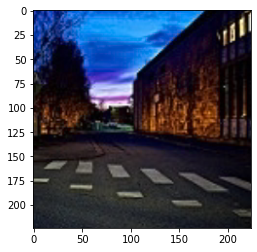

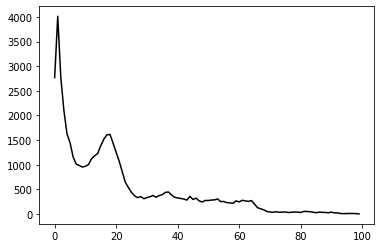

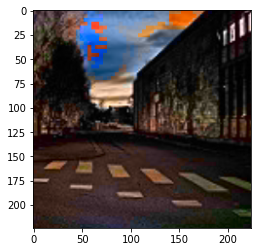

In [35]:
args = AttrDict()
args_dict = {
              'model_path': './model/', 
              'batch_size': 40,
              'image_dir': 'new',
              'model': 240,
              'plt': True,
              'shuffle': True,
              'save_img': False
}
args.update(args_dict)
test(args)

In [0]:
color_map('./resources/hist.csv')
hist_from_prob('./resources/rebal_weight.csv')

ab_histogram_single('./activation/target.jpg', './resources/target_hist.npy')
ab_histogram_single('./activation/predict.jpg', './resources/predict_hist.npy')
    
top10_to_csv('./activation/top10.npy', './activation/top10.csv')

npy2csv_hist('./resources/target_hist.npy', './activation/target_hist.csv')
npy2csv_hist('./resources/predict_hist.npy', './activation/predict_hist.csv')

hist2non_zero_csv('./resources/pts.csv')

# **Computing Accuracies**

In [0]:
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
from google.colab import files
from skimage import color
import matplotlib.pyplot as plt


remainder_set = ImageFolder('./scenes', train_transform)
remainder_loader = ImageLoader(remainder_set, 39, True, 2, True)
colours = np.load('./resources/pts.npy', encoding="latin1")

def compute_accuracy(args):
    test_set = ImageFolder("./{}/".format(args.image_dir), test_transform)
    test_loader = ImageLoader(test_set, 1, args.shuffle, 2, True)

    model = nn.DataParallel(Color_model_Vis(num_color_out, 64)).cuda()
    model.load_state_dict(torch.load(args.model_path + "model-{}-290.ckpt".format(args.model)))

    encode_layer = EncodeMax(32, 0.5, args.batch_size)
    # boost_layer = ColorRebal(0.5)
    # nongray_mask = GrayScaleMask()
    
    correct1, correct2, total = 0, 0, 0
    for i, batch in enumerate(zip(test_loader, remainder_loader)):
        images = torch.cat([batch[0][0], batch[1][0]], dim=0)
        img_ab = torch.cat([batch[0][1], batch[1][1]], dim=0)

        images = images.unsqueeze(1).float().cuda()
        img_ab = img_ab.float()
        encode, max_encode = encode_layer.forward(img_ab) # (40, 199, 56, 56)
        targets = torch.Tensor(max_encode).long().cuda()
        
        im_c = images[0][0].cpu()
        outputs = model(images, 0.38)
        _, predicted = torch.max(outputs.data, 1)

        ab = nn.Upsample(scale_factor=4)(img_ab)
        ab = ab[0].cpu().data.numpy()
        
        a = images[0].cpu().data.numpy()
        t = np.concatenate((a + 50.0,ab), axis=0).transpose(1,2,0)
        t = color.lab2rgb(t)

        c = np.expand_dims(colours[predicted[0].cpu()].transpose(2,0,1), axis=0)
        c = nn.Upsample(scale_factor=4)(torch.from_numpy(c))[0].cpu().data.numpy()

        p = np.concatenate((a + 50.0,c), axis=0).transpose(1,2,0)
        p = color.lab2rgb(p)

        pab = np.concatenate((np.zeros(a.shape) + 50.0,c), axis=0).transpose(1,2,0)
        pab = color.lab2rgb(pab)

        diff = colours[predicted[0].cpu()] - colours[targets[0].cpu()]
        diff_img = diff[...,0]**2 + diff[...,1]**2
        count1 = (diff_img <= 100).sum()
        count2 = (diff_img <= 0).sum()
        di = diff_img <= 100

        if args.plt:
            plt.imshow(im_c)
            plt.show()
            plt.imshow(t)
            plt.show()
            plt.imshow(p)
            plt.show()
            plt.imshow(pab)
            plt.show()
            plt.imshow(di)
            plt.show()
        if args.save_img:
            plt.imsave('./images_epoch/{}/{}/{}-{}.jpg'.format(args.model, args.image_dir, i, 'im_c'), im_c)
            plt.imsave('./images_epoch/{}/{}/{}-{}.jpg'.format(args.model, args.image_dir, i, 't'), t)
            plt.imsave('./images_epoch/{}/{}/{}-{}.jpg'.format(args.model, args.image_dir, i, 'p'), p)
            plt.imsave('./images_epoch/{}/{}/{}-{}.jpg'.format(args.model, args.image_dir, i, 'pab'), pab)
            plt.imsave('./images_epoch/{}/{}/{}-{}.jpg'.format(args.model, args.image_dir, i, 'di'), di)
        
        batch_total = np.ones(targets[0].shape).sum()
        correct1 += count1
        correct2 += count2
        total += batch_total
        # print("accu: {}".format(100 * count1/batch_total))
        # print("accu: {}".format(100 * count2/batch_total))

        if i == args.test_size-1: break
    accu1 = 100 * correct1/total
    accu2 = 100 * correct2/total
    print("correct1: {} total: {} accu: {}".format(correct1, total, accu1))
    print("correct2: {} total: {} accu: {}".format(correct2, total, accu2))
    return accu1, accu2


In [0]:
args = AttrDict()
args_dict = {
              'model_path': './model/', 
              'batch_size': 40,
              'image_dir': 'mountain',
              'model': 460,
              'plt': True,
              'test_size': 10,
              'shuffle': False,
              'save_img': False
}
args.update(args_dict)
compute_accuracy(args)

In [0]:
import warnings
warnings.filterwarnings("ignore")

args = AttrDict()
args_dict = {
              'model_path': './checkpoints/', 
              'batch_size': 40,
              'image_dir': './mountain',
              'model': 'model-460-290.ckpt',
              'plt': False,
              'test_size': 20,
              'shuffle': False,
              'save_img': True
}
args.update(args_dict)
cate = ['mountain', 'forest', 'buildings', 'sea', 'street']
accu1_table = []
accu2_table = []

for model_num in range(204,404,4):
    print(model_num)
    row1 = []
    row2 = []

    args_dict['model'] = str(model_num)
    for folder in cate:
        print(folder)
        args_dict['image_dir'] = folder
        args.update(args_dict)
        accu1, accu2 = compute_accuracy(args)

        row1.append(accu1)
        row2.append(accu2)

    accu1_table.append(row1)
    accu2_table.append(row2)

accu1_table = np.array(accu1_table)
accu2_table = np.array(accu2_table)

if os.path.exists('./resources/accu1.npy'):
    accu1_table = np.vstack([np.load('./resources/accu1.npy'), accu1_table])
if os.path.exists('./resources/accu2.npy'):
    accu2_table = np.vstack([np.load('./resources/accu2.npy'), accu2_table])

np.save('./resources/accu1.npy', accu1_table)
np.save('./resources/accu2.npy', accu2_table)